# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [2]:
import tensorflow as tf

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

2023-11-07 22:06:06.075305: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 22:06:06.767940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 22:06:06.767973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 22:06:06.771893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 22:06:07.119333: I tensorflow/core/platform/cpu_feature_g

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [3]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

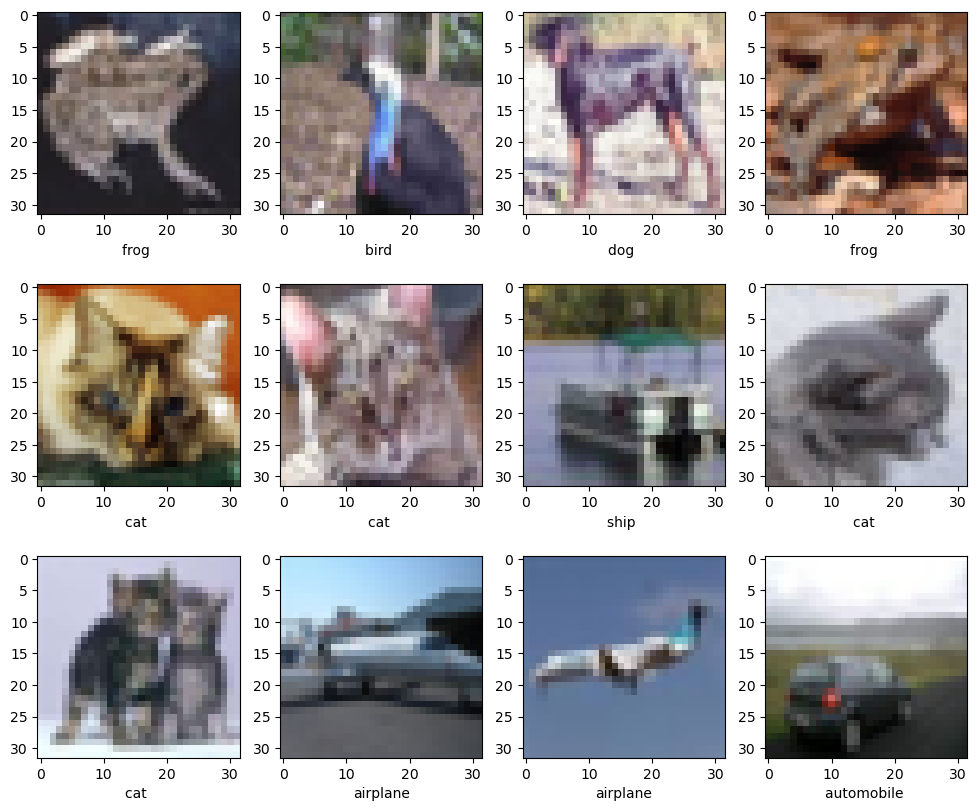

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [5]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [6]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [7]:
import keras
from keras import layers as L
from keras import backend as K

In [8]:
from keras.utils import to_categorical

y_test = to_categorical(y_test, num_classes=10)
y_train = to_categorical(y_train, num_classes=10)

In [9]:
y_train.shape

(40000, 10)

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),  # Вытягиваем картинку в вектор
    keras.layers.Dense(128, activation='relu'), # Полносвязный слой с 128 нейронами и функцией активации ReLU
    keras.layers.Dense(10, activation='softmax')    # Выходной слой с 10 нейронами и функцией активации softmax
])

2023-11-07 22:06:16.575578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 22:06:16.779272: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 183ms/step
Успех!


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [13]:
# y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True),  # Сохранение чекпоинта лучшей модели
    keras.callbacks.EarlyStopping(patience=5),  # Остановка обучения, если в течение 5 эпох нет улучшения
]


In [15]:
model.compile(
    optimizer=keras.optimizers.SGD(
    momentum=0.9,
    nesterov=True),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [16]:
model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=100,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
)

Epoch 1/10
400/400 [==============================] - 2s 5ms/step - loss: 1.8462 - accuracy: 0.3417 - val_loss: 1.7026 - val_accuracy: 0.3896
Epoch 2/10
400/400 [==============================] - 1s 4ms/step - loss: 1.6682 - accuracy: 0.4103 - val_loss: 1.6113 - val_accuracy: 0.4367
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 1.5935 - accuracy: 0.4385 - val_loss: 1.5901 - val_accuracy: 0.4440
Epoch 4/10
400/400 [==============================] - 1s 4ms/step - loss: 1.5463 - accuracy: 0.4543 - val_loss: 1.5289 - val_accuracy: 0.4607
Epoch 5/10
400/400 [==============================] - 1s 4ms/step - loss: 1.5125 - accuracy: 0.4640 - val_loss: 1.5328 - val_accuracy: 0.4555
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 1.4832 - accuracy: 0.4765 - val_loss: 1.4941 - val_accuracy: 0.4702
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 1.4576 - accuracy: 0.4821 - val_loss: 1.5137 - val_accuracy: 0.4651
Epoch 

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [18]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

# Преобразование меток y_test обратно в одномерный вектор
y_test_flat = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_test_flat, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


313/313 [==============================] - 0s 1ms/step

 Test_acc = 0.4621
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Создаем пустую модель
model_cnn = Sequential()

# Входной слой (размер входа 32x32x3)
# Первый сверточный слой 3x3 с 10 фильтрами и нелинейностью ReLU
model_cnn.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))

# Max-pooling слой 2x2
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Вытягиваем в вектор (Flatten)
model_cnn.add(Flatten())

# Полносвязный слой на 100 нейронов и нелинейностью ReLU
model_cnn.add(Dense(100, activation='relu'))

# Выходной полносвязный слой с функцией активации softmax
model_cnn.add(Dense(10, activation='softmax'))

In [20]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 10)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 2250)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               225100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 226390 (884.34 KB)
Trainable params: 226390 (884.34 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [21]:
model_cnn.compile(
    optimizer=keras.optimizers.SGD(
    momentum=0.9,
    nesterov=True),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [22]:
model_cnn.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=100,
    validation_data=(X_test, y_test)
)

Epoch 1/10
400/400 [==============================] - 3s 6ms/step - loss: 1.8163 - accuracy: 0.3548 - val_loss: 1.5818 - val_accuracy: 0.4451
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 1.4886 - accuracy: 0.4717 - val_loss: 1.3871 - val_accuracy: 0.5059
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 1.3143 - accuracy: 0.5382 - val_loss: 1.2749 - val_accuracy: 0.5506
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 1.2130 - accuracy: 0.5731 - val_loss: 1.2453 - val_accuracy: 0.5581
Epoch 5/10
400/400 [==============================] - 2s 6ms/step - loss: 1.1457 - accuracy: 0.5972 - val_loss: 1.2425 - val_accuracy: 0.5613
Epoch 6/10
400/400 [==============================] - 2s 6ms/step - loss: 1.0934 - accuracy: 0.6179 - val_loss: 1.1939 - val_accuracy: 0.5802
Epoch 7/10
400/400 [==============================] - 2s 6ms/step - loss: 1.0405 - accuracy: 0.6353 - val_loss: 1.1948 - val_accuracy: 0.5848
Epoch 

In [23]:
from sklearn.metrics import accuracy_score

predict_x = model_cnn.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

# Преобразование меток y_test обратно в одномерный вектор
y_test_flat = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_test_flat, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.5817
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [33]:
from tensorflow import keras

class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            y_pred = model.predict(X_test)
            predicted_classes = np.argmax(y_pred, axis=1)
            y_test_int = np.argmax(y_test, axis=1)  # Преобразование one-hot меток в целевые классы
            accuracy = metric(y_test_int, predicted_classes)
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name, accuracy))



In [34]:
!rm -rf ./logs

In [35]:
# optimizers = {
#     # 'optimizer_name': optimizer
# }


from tensorflow.keras import optimizers
optimizers = { 'SGD': optimizers.legacy.SGD(),
               'Adam': optimizers.legacy.Adam(),
               'RMSprop': optimizers.legacy.RMSprop(),
              }


In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Создаем модель
model_comp = Sequential()
model_comp.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_comp.add(MaxPooling2D(pool_size=(2, 2)))
model_comp.add(Flatten())
model_comp.add(Dense(100, activation='relu'))
model_comp.add(Dense(10, activation='softmax'))

# model_adam = Sequential()
# model_adam.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model_adam.add(MaxPooling2D(pool_size=(2, 2)))
# model_adam.add(Flatten())
# model_adam.add(Dense(100, activation='relu'))
# model_adam.add(Dense(10, activation='softmax'))

# model_pmsprop = Sequential()
# model_pmsprop.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model_pmsprop.add(MaxPooling2D(pool_size=(2, 2)))
# model_pmsprop.add(Flatten())
# model_pmsprop.add(Dense(100, activation='relu'))
# model_pmsprop.add(Dense(10, activation='softmax'))


# # Собираем модели и оптимизаторы в словари
# models = {'model_sqd': model_sqd, 'model_adam': model_adam, 'model_pmsprop': model_pmsprop}

In [27]:
evaluator = Evaluator(model_comp, optimizers=optimizers)

In [28]:
evaluator

[('single_model',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7ff6105e7760>),
 ('single_model',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7ff6105e7940>),
 ('single_model',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7ff6105e77f0>)]

Прокомментируйте полученные результаты.

In [29]:
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of single_model_SGD is 0.5248
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.572
313/313 [==============================] - 1s 2ms/step
Final score of single_model_RMSprop is 0.5741


Как можно быть таким глупым человеком и создавать на каждый оптимизатор зачем-то свою модель, а потом именно ее использовать в evaluator, тем самым 3 модели на 3 оптимизатора = 9 обучений. Примерно час пыталась чего-то добиться, а потом поняла в чем ошибка. <b> Еще не понимаю как использовать evaluate и получить точность не делая преобразование one-hot меток в целевые классы... </b>   

SGD - 0.5381   
Adam - 0.5903     
RMSprop - 0.5976   

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [37]:
from collections import OrderedDict
from keras.layers import BatchNormalization

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [38]:
# # Create a base model
# base_model = Sequential()
# base_model.add(Conv2D(10, (3, 3), input_shape=(32, 32, 3), activation='relu'))
# base_model.add(MaxPooling2D(pool_size=(2, 2)))
# base_model.add(Flatten())
# base_model.add(Dense(100, activation='relu'))
# base_model.add(Dense(10, activation='softmax'))

# # Create a Models instance
# models = Models({'base_model': base_model})

# # Add layers to all models
# batch_norm_layer = BatchNormalization(name='batch_normalization1')  # Set a unique name
# models.add(batch_norm_layer)

# # Create a new model with a BatchNormalization layer added
# models.add_create('model_with_batch_norm', BatchNormalization(name='batch_normalization2'))

In [39]:
!rm -rf ./logs

In [40]:
full_norm = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),  # Add BatchNormalization layer here
    keras.layers.Dense(10, activation='softmax')
])

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation

cnn_norm = Sequential()
cnn_norm.add(Conv2D(10, (3, 3), input_shape=(32, 32, 3), activation='relu'))
cnn_norm.add(MaxPooling2D(pool_size=(2, 2)))
cnn_norm.add(Flatten())
cnn_norm.add(Dense(100))
cnn_norm.add(BatchNormalization())  # Add BatchNormalization
cnn_norm.add(Activation('relu'))  # Add ReLU activation after BatchNormalization
cnn_norm.add(Dense(10, activation='softmax'))


In [42]:
models = Models({'full_with_norm': full_norm, 'cnn_with_norm': cnn_norm})

In [43]:
# Display the model summary for the base model
print("full_with_norm")
models['full_with_norm'].summary()

# Display the model summary for the model with BatchNormalization layer
print("\ncnn_with_norm:")
models['cnn_with_norm'].summary()

full_with_norm
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               393344    
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 395146 (1.51 MB)
Trainable params: 394890 (1.51 MB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________

cnn_with_norm:
Model: "sequential_7"
_______________________________

In [38]:
evaluator = Evaluator(models, optimizers=optimizers)

In [39]:
evaluator

[('full_with_norm',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7ff6105e7760>),
 ('full_with_norm',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7ff6105e7940>),
 ('full_with_norm',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7ff6105e77f0>),
 ('cnn_with_norm',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7ff6105e7760>),
 ('cnn_with_norm',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7ff6105e7940>),
 ('cnn_with_norm',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7ff6105e77f0>)]

In [40]:
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 0s 1ms/step
Final score of full_with_norm_SGD is 0.3957
313/313 [==============================] - 0s 1ms/step
Final score of full_with_norm_Adam is 0.4171
313/313 [==============================] - 0s 1ms/step
Final score of full_with_norm_RMSprop is 0.4012
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_SGD is 0.4592
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_Adam is 0.6111
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_RMSprop is 0.5629


In [42]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 0s 1ms/step
Final score of single_model_SGD is 0.4381
313/313 [==============================] - 0s 1ms/step
Final score of single_model_Adam is 0.298
313/313 [==============================] - 0s 1ms/step
Final score of single_model_RMSprop is 0.3999


In [43]:
evaluator = Evaluator(model_cnn, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 1s 2ms/step
Final score of single_model_SGD is 0.4794
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.5742
313/313 [==============================] - 1s 2ms/step
Final score of single_model_RMSprop is 0.6079


Прокомментируйте полученные результаты.

| Модель             | SGD    | Adam   | RMSprop |
|--------------------|--------|--------|---------|
| Полносвязная (norm)      | 0.4177 | 0.3887 | 0.3839  |
| Полносвязная      | 0.4456 | 0.3358 | 0.4071  |
| Сверточная (norm)       | 0.5125 | 0.5902 | 0.5682  |
| Сверточная        | 0.5109 | 0.5504 | 0.6096  |

Таким образом, мы видим, что результаты слишком незначительны, чтобы добавлять один слой batch normalization   

**Надеюсь, что это нормально...**

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [45]:
from keras.callbacks import EarlyStopping

# Определите EarlyStopping коллбэк
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

In [46]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=100, callbacks=[early_stopping])

  0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_SGD is 0.4478
313/313 [==============================] - 0s 1ms/step
Final score of full_with_norm_Adam is 0.4361
313/313 [==============================] - 0s 1ms/step
Final score of full_with_norm_RMSprop is 0.4388
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_SGD is 0.6155
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_Adam is 0.6197
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_RMSprop is 0.6389


| Модель             | SGD    | Adam   | RMSprop |
|--------------------|--------|--------|---------|
| Полносвязная (norm)      | 0.4177 | 0.3887 | 0.3839  |
| Полносвязная (stop)      | 0.4348 | 0.4448 | 0.4366  |
| Полносвязная      | 0.4456 | 0.3358 | 0.4071  |
| Сверточная (norm)       | 0.5125 | 0.5902 | 0.5682  |
| Сверточная (stop)       | 0.6223 | 0.6326 | 0.6130  |
| Сверточная        | 0.5109 | 0.5504 | 0.6096  |

Как можно заметить, результаты улучшились!

`monitor` - это метрика, которую мы отслеживаем (в данном случае, точность на валидационном наборе)   
 `patience` - количество эпох без улучшений, после которого обучение будет прекращено   
  `restore_best_weights=True` позволяет восстановить веса модели до наилучшей эпохи

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [87]:
# Функция для построения графиков
def plot_training_history(history, optimizer, normalization):
    # Вывести графики потерь и точности
    plt.figure(figsize=(12, 6))

    # Вывести графики потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    plt.grid(True)
    
    # Вывести графики точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)
    
    # Добавить общую подпись
    plt.suptitle(f'Optimizer: {optimizer}, Normalization: {normalizations[1].name if normalization else normalization}', fontsize=14)

    plt.show()


Epoch 1/2
1250/1250 [==============================] - 5s 3ms/step - loss: 1.9293 - accuracy: 0.3128 - val_loss: 1.7742 - val_accuracy: 0.3747
Epoch 2/2
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7575 - accuracy: 0.3729 - val_loss: 1.6840 - val_accuracy: 0.4077


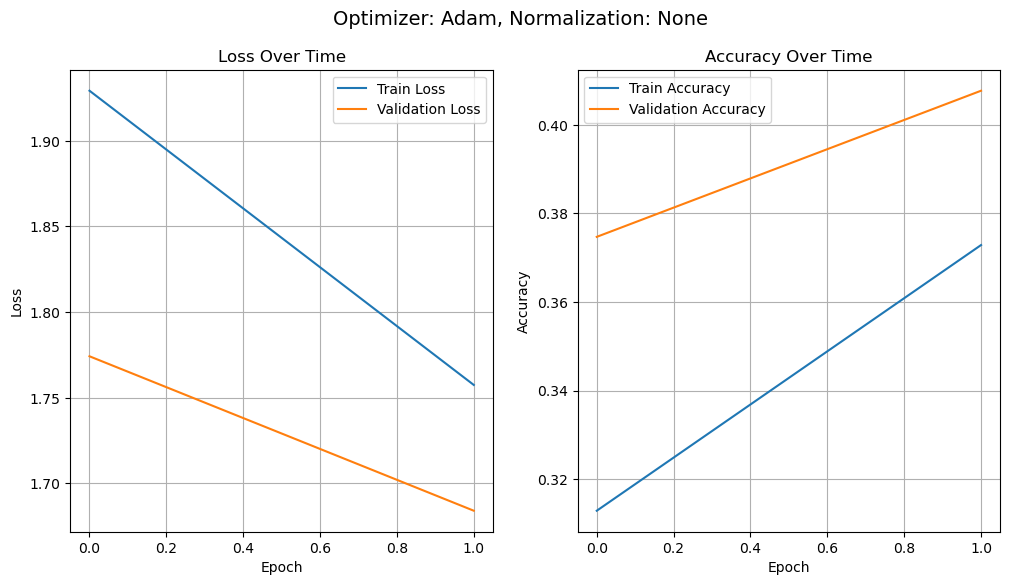

Optimizer: Adam, Normalization: None, Validation Accuracy: 0.4077000021934509
Epoch 1/2
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8251 - accuracy: 0.3643 - val_loss: 1.8612 - val_accuracy: 0.3543
Epoch 2/2
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7291 - accuracy: 0.3991 - val_loss: 1.7742 - val_accuracy: 0.3609


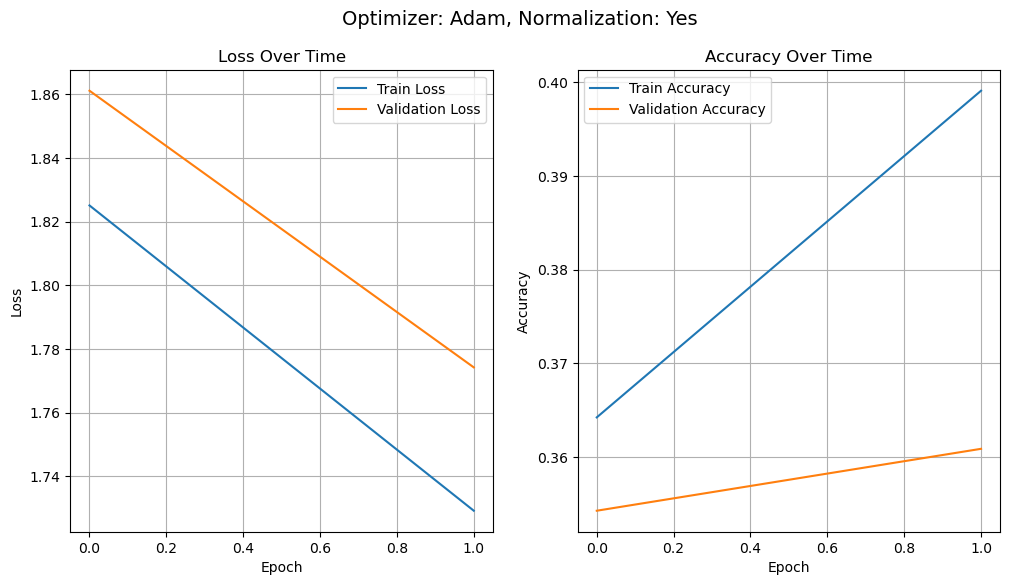

Optimizer: Adam, Normalization: Yes, Validation Accuracy: 0.36090001463890076
Best combination: Optimizer: Adam, Normalization: None, Best Validation Accuracy: 0.4077000021934509


In [88]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

normalizations = [None, BatchNormalization(name='Yes')]

# Задайте другие гиперпараметры
batch_size = 32
epochs = 10


# Создайте функцию для поиска наилучшей комбинации
def find_best_combination(optimizer, normalization):
    # Создайте модель
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(32 * 32 * 3,)))

    if normalization:
        model.add(normalization)

    model.add(Dense(10, activation='softmax'))

    # Компилируйте модель с выбранным оптимизатором
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Обучите модель
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    return history

best_accuracy = 0.0
best_combination = None

# Переберите оптимизаторы и методы нормализации
for optimizer in optimizers:
    for normalization in normalizations:
        history = find_best_combination(optimizer, normalization)
        # Вывести графики потерь
        plot_training_history(history, optimizer, normalization)

        # Оцените наилучшую комбинацию
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Optimizer: {optimizer}, Normalization: {normalizations[1].name if normalization else normalization}, Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_combination = (optimizer, normalization)

print(f"Best combination: Optimizer: {best_combination[0]}, Normalization: {best_combination[1]}, Best Validation Accuracy: {best_accuracy}")


In [89]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [90]:
print(f"Best combination: Optimizer: {best_combination[0]}, Normalization: {best_combination[1]}, Best Validation Accuracy: {best_accuracy}")

Best combination: Optimizer: Adam, Normalization: None, Best Validation Accuracy: 0.4077000021934509


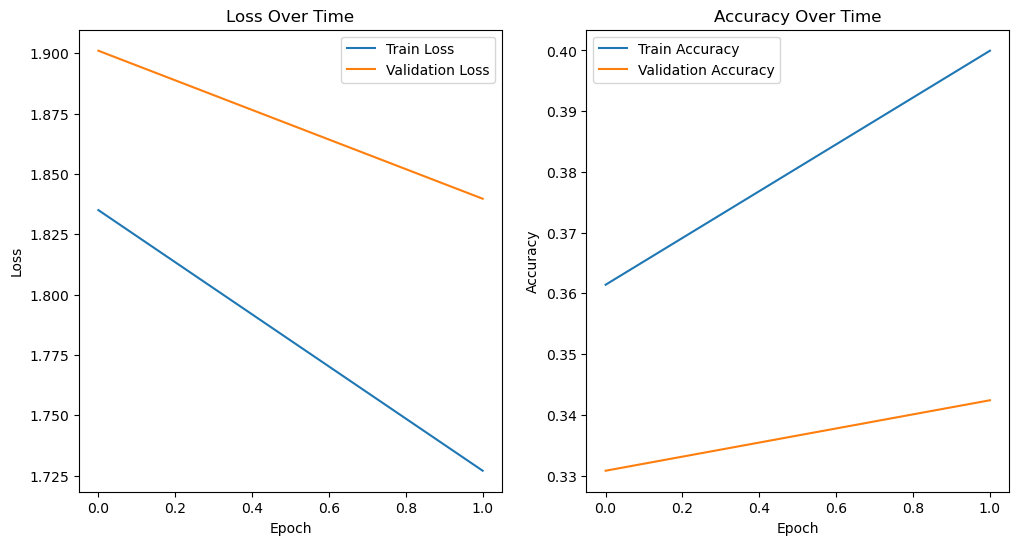

In [52]:
# Вывести графики потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

# Вывести графики точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [13]:
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (x_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


In [14]:
x_train=x_train/255
x_test=x_test/255
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [25]:
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(x_train,y_train_cat,epochs=3,validation_data=(x_test,y_test_cat))

Epoch 1/3
1250/1250 [==============================] - 62s 50ms/step - loss: 1.5273 - accuracy: 0.4593 - val_loss: 1.1454 - val_accuracy: 0.5845
Epoch 2/3
1250/1250 [==============================] - 61s 49ms/step - loss: 1.1418 - accuracy: 0.5971 - val_loss: 0.9218 - val_accuracy: 0.6741
Epoch 3/3
1250/1250 [==============================] - 61s 49ms/step - loss: 0.9608 - accuracy: 0.6645 - val_loss: 0.8541 - val_accuracy: 0.7026


In [28]:
evaluation = model.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 4s 13ms/step - loss: 0.8541 - accuracy: 0.7026
Test Accuracy: 0.7026000022888184


<AxesSubplot:>

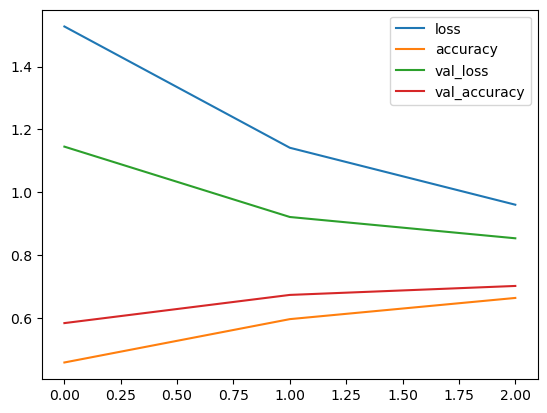

In [31]:
import pandas as pd
pd.DataFrame(history5.history).plot()

Момент истины: проверьте, какого качества достигла ваша сеть.

In [34]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 13ms/step

 Test_acc = 0.7026


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

TODO: 1) доделать последнюю модель нормально 2) оформить весь код 3) перезапустить все в коллабе (2 часа на обучения)